In [71]:
from data_sim_module import plot_pca_fi, get_curve_samples, multi_partite_distance, get_questionnaires, \
                            get_true_mds, compute_mds, align_pca_mds, corr_between_coords, get_pca, \
                            get_t_sne, get_ans_dict

import pandas as pd
import numpy as np
import scipy.stats
import pickle

from scipy.spatial.distance import hamming

from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(6, 5)})

import sys
sys.path.append("../../../data/")

from DimensionReduction import DiffusionMaps, Grassmann
from DiffusionEquation import diffusion
from electric_potential import function
from rand_cmap import rand_cmap

In [2]:
number_q = 8
number_a = 3
N = number_a**number_q

kappa = [1, 2, N-1, 1, 2, N-1]
m = 3

num_samples   = [20, 20, 20, 50, 50, 50]
num_responses = [25, 25, 25, 50, 50, 50]

# Generate 30 questionnaires per param combination

In [141]:
questionnaires = {}

for k in [1, 2, N-1]:
    for n in [20, 50]:
        
        key = (k, n)
        print(key)
        
        if key not in questionnaires:
            questionnaires[key] = {"questionnaires":[]}
        
        # PDFs
        probs = get_curve_samples(number_q=8, number_a=3, samples=n, m=3, sin_angle=k-1)
        questionnaires[key]["probs"] = probs
        
        # MI distances
        MI = multi_partite_distance(probs)
        questionnaires[key]["MI"] = MI
        
        # theoretical embedding
        true_mds = get_true_mds(probs)
        questionnaires[key]["theoretical_embedding"] = true_mds
        
        # generate sample questionnaires
        for rep in range(30):
            if n == 20:
                df = get_questionnaires(probs, count_answers=25, number_q=8, number_a=3)
            else:
                df = get_questionnaires(probs, count_answers=50, number_q=8, number_a=3)
            questionnaires[key]["questionnaires"].append(df)
            
with open("../../../questionnaires.pickle", "wb") as f:
    pickle.dump(questionnaires, f)

(1, 20)
(1, 50)
(2, 20)
(2, 50)
(6560, 20)
(6560, 50)


In [11]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [12]:
def tsne_alg(df, columns, dim=2, perplexity=1, learning_rate=50, **kwargs):
    """ Computes a T-SNE on the samples, to test how this performs in
    comparison with FINE.
    """
    assert isinstance(df, pd.DataFrame)
    assert len(columns) > 1

    # data = StandardScaler().fit_transform(df[columns])
    data = OneHotEncoder(sparse=False).fit_transform(df[columns])

    tsne = TSNE(n_components=dim, perplexity=perplexity, 
                learning_rate=learning_rate, init="pca", **kwargs).fit_transform(data)
    subaks = sorted(df.name_1.unique())
    tsne_coords = np.zeros(shape=(len(subaks), dim))
    for i, s in enumerate(subaks):
        # Compute the position of the Subak in the PCA space
        ind = df[df.name_1 == s].index
        tsne_coords[i, :] = np.mean(tsne[ind], axis=0)

    return tsne_coords

### Plot results from LISA

In [13]:
class GDMaps:
    """
    Performs GDMaps for a given dataset.
    n_evecs must be greater than n_parsim
    """

    def __init__(self, data, n_evecs, n_parsim, p, verbose=False):
        self.data = data
        self.n_evecs = n_evecs
        self.n_parsim = n_parsim
        self.p = p
        self.verbose = verbose

    def get(self):
        Gr = Grassmann(distance_method=Grassmann.grassmann_distance, kernel_method=Grassmann.projection_kernel,
                       karcher_method=Grassmann.gradient_descent)
        Gr.manifold(p=self.p, samples=self.data)

        dfm = DiffusionMaps(alpha=0.5, n_evecs=self.n_evecs + 1, kernel_object=Gr, kernel_grassmann='prod')
        g, evals, evecs = dfm.mapping()

        # Parsimonious representation
        index, residuals = dfm.parsimonious(num_eigenvectors=self.n_evecs, visualization=False)

        coord = index[1:self.n_parsim + 1]

        g_k = g[:, coord]

        # g_k = g[:, 1:]  # without parsimonious
        # coord = np.arange(1, g_k.shape[1]+1)  # diffusion coordinates numbers

        print('Grassmann projection rank is: ', Gr.p)

        return g_k, coord, Gr, residuals, index, evals


def plot_diff_coord(x, data, coord, labels):
    """
    Plots the diffusion coordinates from the GDMaps.
    """
    plt.rcParams.update({'font.size': 24})

    nlabels = np.unique(labels).shape[0]
    cmap = rand_cmap(nlabels=nlabels, type='bright', first_color_black=False)

    comb1 = list(it.combinations(list(coord), 2))
    comb2 = list(it.combinations([i for i in range(coord.shape[0])], 2))

    if os.path.exists('figures'):
        command = ['rm', '-r', 'figures']
        subprocess.run(command)

    command = ['mkdir', 'figures']
    subprocess.run(command)

    for i in range(len(comb1)):
        plt.figure(figsize=(8, 6), constrained_layout=True)
        plt.scatter(data[:, comb2[i][0]], data[:, comb2[i][1]], s=30, c=labels, cmap=cmap)
        plt.xlabel(r'$\psi_{}$'.format(comb1[i][0]), fontsize=26)
        plt.ylabel(r'$\psi_{}$'.format(comb1[i][1]), fontsize=26)
        plt.grid(True)
        plt.savefig('figures/Psi_{},{}.png'.format(comb1[i][0], comb1[i][1]), bbox_inches='tight')

    # Plot first three plots
    if coord.shape[0] > 2:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22, 5), constrained_layout=True)
        for i in range(3):
            ax[i].scatter(data[:, comb2[i][0]], data[:, comb2[i][1]], s=30, c=labels, cmap=cmap)
            ax[i].set_xlabel(r'$\psi_{}$'.format(comb1[i][0]), fontsize=28)
            ax[i].set_ylabel(r'$\psi_{}$'.format(comb1[i][1]), fontsize=28)
            ax[i].grid('True')
            ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
            # plt.legend()
            # ax[i].set_title('Training realizations: {}'.format(trunc[i]))
        plt.savefig('figures/Diffusion-coord.png', bbox_inches='tight', dpi=300)

    fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)
    plt.scatter(x[:, 0], x[:, 1], c=labels, cmap=cmap)
    plt.xlabel(r'$x_1$', fontsize=22)
    plt.ylabel(r'$x_2$', fontsize=22)
    plt.title('Input parameters colored by \n the clusters on diffusion manifold')
    plt.savefig('figures/stochastic-inputs.png', bbox_inches='tight', dpi=300)

In [14]:
# code is adapted from:
# https://github.com/arashbehboodi/DiffusionMap


def diffusionmap(distance_mat, n, eps, t, n_eigen, alpha=1/2):
    """
    distance_mat: distance matrix
    t: t indicates the number of iterations.
    n_eigen: indicates the target dimension for dimensionality reduction
    eps: is the parameter of Guassian kernel that is used.
    """    
    
#     # Finding the distance matrix"
#     covariance_matrix = data_matrix@data_matrix.T

#     distance_mat_1 = -2*covariance_matrix
#     distance_mat_2 = np.outer(np.diag(covariance_matrix), np.ones((n, 1))) + np.outer(np.ones((n, 1)), np.diag(covariance_matrix).T)
#     distance_mat = distance_mat_1+distance_mat_2

    # Kernel function for weight matrx: Gaussian Kernel
    # Constructing the weight matrix
    W = np.exp(-distance_mat/eps)
    
    # Degree matrix
    Deg = W@np.ones((n, 1))
    D = np.diag(Deg.reshape(n,))
    
    # Transition matrix
    M = np.linalg.inv(D)@W
    
    # Constructing the matrix S - obtaining diffusion vectors
    S = D**(alpha)@M@np.linalg.inv(D)**(alpha)
    
    # Spectral decomposition
    eigvalCov, eigvecCov = np.linalg.eig(S)
    idx = eigvalCov.argsort()[::-1]
    eigvalCov = eigvalCov[idx]
    eigvecCov = eigvecCov[:, idx]
    
    # Diffusion Map
    phiD = np.linalg.inv(D)**(alpha)@eigvecCov
    lambdaD = eigvalCov**t
    
    # Final Matrix with columns as the vectors
    DiffM = np.diag(lambdaD)@phiD.T
    Difftruncated = DiffM[1:n_eigen+1, :]
    return Difftruncated.T

In [15]:
def weighted_hamming(X):
    # compute number of categories per feature
    pi_k = np.zeros(len(X.columns))
    for i, col in enumerate(X.columns):
        pi_k[i] = len(X[col].unique())
    pi_k = 1/pi_k

    X = np.array(X)

    H = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            hamming = np.sum(np.array(X[i] != X[j]) * pi_k)
            H[i][j] = hamming
            H[j][i] = hamming
            
    return H

Grassmann projection rank is:  1
Grassmann projection rank is:  1
Grassmann projection rank is:  1
Grassmann projection rank is:  1
Grassmann projection rank is:  1
Grassmann projection rank is:  1


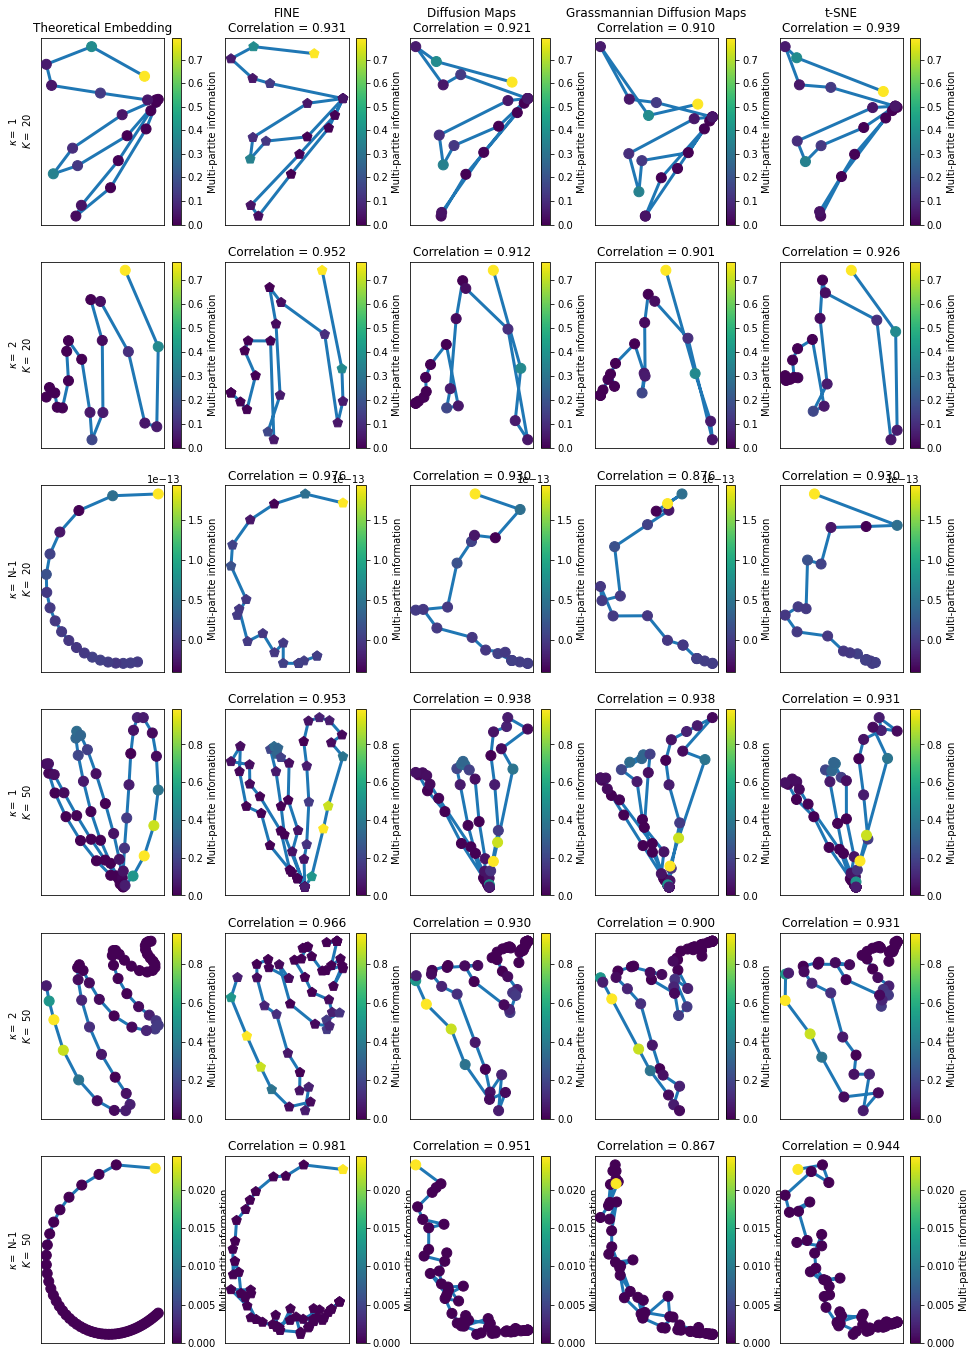

In [10]:
plt.figure(figsize=(16,24))

dim = 2

for i in range(6):
    
    with open(f"../LISA/tsne_embedding/results/{i}.pickle", "rb") as f:
        data = pickle.load(f)
        
    KLs = data["KLs"]
    df = data["df"]
        
    # theoretical embedding
    true_mds = data["true_coords"]
    
    plt.subplot(6, 5, 5*i+1)
    plt.scatter(true_mds[:,0], true_mds[:,1], marker='o', label="True FI", c=KLs, s=100, zorder=3)
    plt.plot(true_mds[:,0], true_mds[:,1], label="True FI", lw=3, zorder=2)
    if i == 0:
        plt.title("Theoretical Embedding")
    plt.xticks([])
    plt.yticks([])
    if i in [0, 3]:
        kappa = "1"
    elif i in [1, 4]:
        kappa = "2"
    else:
        kappa = "N-1"
    if i < 3:
        K = "20"
    else:
        K = "50"
    plt.ylabel(r"$\kappa = $ " + kappa + "\n" + r"$K = $ " + K)
    plt.colorbar(label="Multi-partite information")
    
    # Fisher information
    _, mds_joint = compute_mds(df, dim=dim, compute_joint=True)
    mds_joint = align_pca_mds(true_mds, mds_joint)
    fi_corr = corr_between_coords(true_mds, mds_joint)
    
    plt.subplot(6, 5, 5*i+2)
    plt.scatter(mds_joint[:,0], mds_joint[:,1], marker='p', label="FI Joint", c=KLs, s=100, zorder=3)
    plt.plot(mds_joint[:,0], mds_joint[:,1],  label="FI Joint", lw=3, zorder=2)
    if i == 0:
        plt.title("FINE\nCorrelation = %.3f" % fi_corr)
    else:
         plt.title("\nCorrelation = %.3f" % fi_corr)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(label="Multi-partite information")
    
    
    # PCA
#     df.name_1 = df.name_1.astype(int)
#     pca, _ = get_pca(df, df.columns.drop("name_1"), dim=dim, align=False)
#     pca = align_pca_mds(true_mds, pca)
#     pca_corr = corr_between_coords(true_mds, pca)
    
    
    # Diffusion maps
    df.name_1 = df.name_1.astype(int)
    subaks = sorted(df.name_1.unique())
    
    X = weighted_hamming(df.loc[:, df.columns!="name_1"])
    dm = np.real(diffusionmap(X, len(df), eps=1, t=0.5, n_eigen=dim))
    dm_coords = np.zeros(shape=(len(subaks), dim))
    
    for k, s in enumerate(subaks):
        ind = df[df.name_1 == s].index
        dm_coords[k,:] = np.mean(dm[ind], axis=0)
    dm = align_pca_mds(true_mds, dm_coords)
    dm_corr = corr_between_coords(true_mds, dm)
    
    plt.subplot(6, 5, 5*i+3)
    plt.scatter(dm[:,0], dm[:,1], label="Diffusion Maps", c=KLs, s=100, zorder=3)
    plt.plot(dm[:,0], dm[:,1], lw=3, zorder=2)
    if i == 0:
        plt.title("Diffusion Maps\nCorrelation = %.3f" % dm_corr)
    else:
        plt.title("\nCorrelation = %.3f" % dm_corr)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(label="Multi-partite information")
    
    
    # Grassmannian Diffusion Maps
    X = np.array(df.loc[:, df.columns!="name_1"])
    gdm = GDMaps(data=X.reshape(X.shape[0], X.shape[1], 1), n_evecs=3, n_parsim=2, p="max")
    gdm_emb = gdm.get()[0]
    gdm_coords = np.zeros(shape=(len(subaks), dim))
    for k, s in enumerate(subaks):
        ind = df[df.name_1 == s].index
        gdm_coords[k,:] = np.mean(gdm_emb[ind], axis=0)
    gdm = align_pca_mds(true_mds, gdm_coords)
    gdm_corr = corr_between_coords(true_mds, gdm)

    plt.subplot(6, 5, 5*i+4)
    plt.scatter(gdm[:,0], gdm[:,1], label="Grassmannian Diffusion Maps", c=KLs, s=100, zorder=3)
    plt.plot(gdm[:,0], gdm[:,1], lw=3, zorder=2)
    if i == 0:
        plt.title("Grassmannian Diffusion Maps\nCorrelation = %.3f" % gdm_corr)
    else:
        plt.title("\nCorrelation = %.3f" % gdm_corr)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(label="Multi-partite information")
    

    # T-SNE
    plt.subplot(6, 5, 5*i+5)
    tsne = data["tsne_coords"]
    tsne_corr = data["corr"]
    
    plt.scatter(tsne[:,0], tsne[:,1], label="t-SNE", c=KLs, s=100, zorder=3)
    plt.plot(tsne[:,0], tsne[:,1],  label="t-SNE", lw=3, zorder=2)
    if i == 0:
        plt.title("t-SNE\nCorrelation = %.3f" % tsne_corr)
    else:
        plt.title("\nCorrelation = %.3f" % tsne_corr)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(label="Multi-partite information")

plt.savefig("latest_embedding_comparison.pdf")
plt.show()

# Results

In [211]:
RESULTS = {}
with open("../../../tsne_results.pickle", "rb") as f:
    RESULTS["tsne"] = pickle.load(f)
with open("../../../fine_results.pickle", "rb") as f:
    RESULTS["fine"] = pickle.load(f)
with open("../../../dm_results.pickle", "rb") as f:
    RESULTS["dm"] = pickle.load(f)

In [212]:
# FINE
fine_means = []
fine_intervals = []
for key, df_dict in RESULTS["fine"].items():
    corrs = []
    for df_idx, df_results in df_dict.items():
        corrs.append(df_results["none"]["corr"])
    conf_int = mean_confidence_interval(corrs)
    fine_means.append(round(conf_int[0],3))
    fine_intervals.append(round(conf_int[1],3))

In [213]:
# TSNE
tsne_means = []
tsne_intervals = []
corrs = {}

for key, df_dict in RESULTS["tsne"].items():
    print(key)
    for df_idx, df_results in df_dict.items():
        for param_combination in df_results:
            if param_combination not in corrs:
                corrs[param_combination] = []
            corrs[param_combination].append(df_results[param_combination]["corr"])
    
    conf_intervals = []
    for param_combination, vals in corrs.items():
        conf_int = mean_confidence_interval(vals)
        conf_intervals.append((param_combination, round(conf_int[0],3), round(conf_int[1],3))) 
    conf_intervals = sorted(conf_intervals, key=lambda x: x[1], reverse=True)[0]
    tsne_means.append(conf_intervals[1])
    tsne_intervals.append(conf_intervals[2])
    print(conf_intervals)
    print()

(1, 20)
(('hamming', 2, 50), 0.891, 0.018)

(1, 50)
(('hamming', 1, 50), 0.898, 0.011)

(2, 20)
(('hamming 1hot', 1, 50), 0.876, 0.01)

(2, 50)
(('hamming 1hot', 1, 50), 0.885, 0.008)

(6560, 20)
(('hamming 1hot', 1, 50), 0.89, 0.007)

(6560, 50)
(('hamming 1hot', 1, 50), 0.898, 0.007)



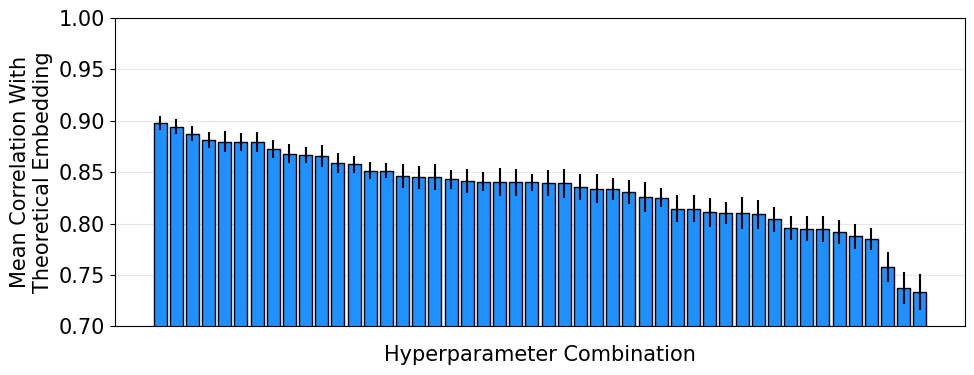

In [218]:
labels = list(corrs.keys())
x = np.arange(len(labels))

param_conf_ints = sorted([(mean_confidence_interval(corrs[k]),k) for k in labels], 
                         key = lambda x:x[0][0], reverse=True)

param_means = [x[0][0] for x in param_conf_ints]
param_intervals = [x[0][1] for x in param_conf_ints]

fig, ax = plt.subplots(figsize=(10,4))

bars = ax.bar(x , param_means, yerr=param_intervals, 
              label='FINE', color="dodgerblue", edgecolor="k")

ax.set_xlabel("Hyperparameter Combination", labelpad=10)
ax.set_ylabel('Mean Correlation With\nTheoretical Embedding')
ax.set_title("")
ax.set_xticks([])
# ax.set_xticks(x, labels, rotation=90)

ax.set_ylim(0.7, 1)

fig.tight_layout()

plt.show()

In [170]:
param_conf_ints

[((0.897898212349089, 0.006551360297413445), ('hamming 1hot', 1, 50)),
 ((0.8941385011218732, 0.00710125373819929), ('hamming 1hot', 2, 50)),
 ((0.8872171279418606, 0.007340967635610314), ('hamming 1hot', 2, 100)),
 ((0.8811540357638553, 0.007702094804786281), ('hamming', 2, 50)),
 ((0.8797398384875423, 0.010043780104921858), ('hamming 1hot', 2, 200)),
 ((0.8796649425425317, 0.008869001780895147), ('hamming', 1, 50)),
 ((0.8791358801984935, 0.009910217681790444), ('hamming 1hot', 1, 100)),
 ((0.8725093508735879, 0.00919204651576561), ('hamming 1hot', 5, 200)),
 ((0.8681104989484401, 0.00916533723075555), ('cosine 1hot', 1, 50)),
 ((0.8666324571668911, 0.008132496690595046), ('cosine 1hot', 2, 50)),
 ((0.8653591283514793, 0.010581416116255864), ('hamming 1hot', 5, 100)),
 ((0.8588402687138742, 0.009480878325308558), ('hamming 1hot', 1, 200)),
 ((0.8575831509169489, 0.00833647116711972), ('hamming 1hot', 5, 50)),
 ((0.8515229187509421, 0.008127978964299542), ('hamming', 5, 50)),
 ((0.851

In [181]:
# DM
dm_means = []
dm_intervals = []
corrs = {}

for key, df_dict in RESULTS["dm"].items():
    print(key)
    for df_idx, df_results in df_dict.items():
        for param_combination in df_results:
            if param_combination not in corrs:
                corrs[param_combination] = []
            corrs[param_combination].append(df_results[param_combination]["corr"])
    
    conf_intervals = []
    for param_combination, vals in corrs.items():
        conf_int = mean_confidence_interval(vals)
        conf_intervals.append((param_combination, round(conf_int[0],3), round(conf_int[1],3))) 
    conf_intervals = sorted(conf_intervals, key=lambda x: x[1], reverse=True)[0]
    dm_means.append(conf_intervals[1])
    dm_intervals.append(conf_intervals[2])
    print(conf_intervals)
    print()

(1, 20)
(('cosine 1hot', 1.5, 0.5), 0.91, 0.008)

(1, 50)
(('cosine 1hot', 1.5, 0.5), 0.921, 0.005)

(2, 20)
(('cosine 1hot', 1.5, 0.5), 0.914, 0.005)

(2, 50)
(('cosine 1hot', 0.5, 0.5), 0.917, 0.004)

(6560, 20)
(('cosine 1hot', 0.5, 0.5), 0.918, 0.003)

(6560, 50)
(('cosine 1hot', 1, 0.5), 0.923, 0.003)



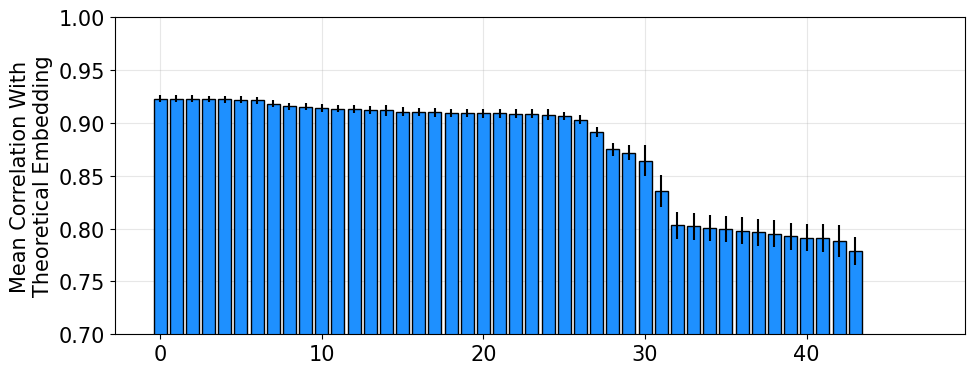

In [187]:
labels = list(corrs.keys())
x = np.arange(len(labels))

param_conf_ints = sorted([(mean_confidence_interval(corrs[k]),k) for k in labels], 
                         key = lambda x:x[0][0], reverse=True)

param_means = [x[0][0] for x in param_conf_ints]
param_intervals = [x[0][1] for x in param_conf_ints]

fig, ax = plt.subplots(figsize=(10,4))

bars = ax.bar(x , param_means, yerr=param_intervals, color="dodgerblue", edgecolor="k")

ax.set_ylabel('Mean Correlation With\nTheoretical Embedding')
ax.set_title("")
# ax.set_xticks(x, labels, rotation=90)
ax.set_ylim(0.7, 1)

fig.tight_layout()

plt.show()

In [183]:
param_conf_ints

[((0.9227616416837054, 0.003185808424466004), ('cosine 1hot', 2, 0.5)),
 ((0.9227421992304055, 0.0031787086815006148), ('cosine 1hot', 1.5, 0.5)),
 ((0.9226653197210081, 0.0031666060938247884), ('cosine 1hot', 1, 0.5)),
 ((0.9225663660519285, 0.003160237783476464), ('hamming', 2, 0.5)),
 ((0.9223096156770398, 0.0031553333876383335), ('hamming', 1.5, 0.5)),
 ((0.9219477750661937, 0.003155833287434784), ('cosine 1hot', 0.5, 0.5)),
 ((0.9213146432647259, 0.003171017857271788), ('hamming', 1, 0.5)),
 ((0.9179503693837898, 0.003298140998965856), ('hamming 1hot', 2, 0.5)),
 ((0.915799981266287, 0.003293597344831582), ('cosine 1hot', 2, 0)),
 ((0.9149813558513429, 0.003330285476614068), ('cosine 1hot', 1.5, 0)),
 ((0.9138848986971819, 0.0037079978084167565), ('hamming 1hot', 1.5, 1)),
 ((0.9131785600879779, 0.0034183582882353976), ('cosine 1hot', 1, 0)),
 ((0.9126534845134018, 0.0038968230050215173), ('hamming 1hot', 2, 1)),
 ((0.9119084026615442, 0.00349200593633882), ('hamming', 2, 0)),
 ((

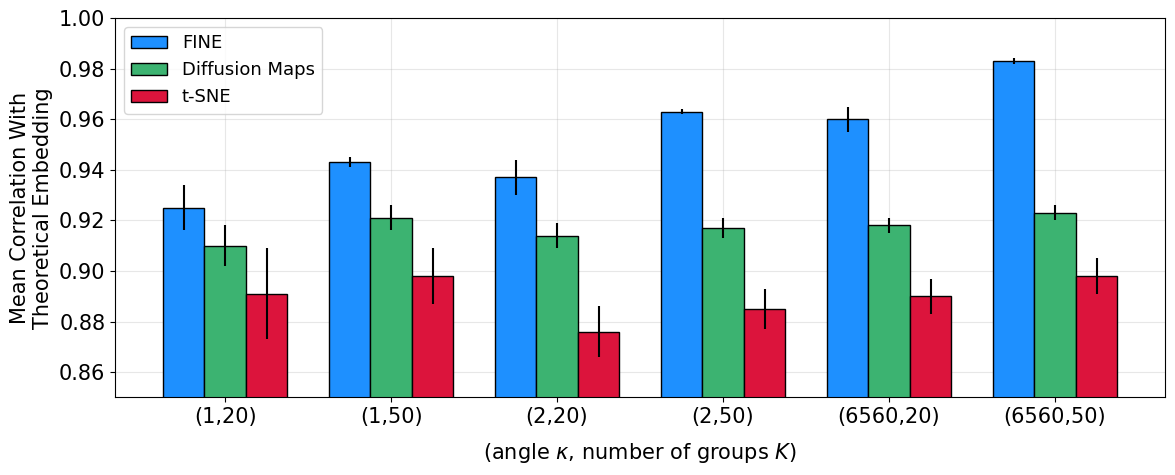

In [203]:
labels = ['(1,20)', '(1,50)', '(2,20)', '(2,50)', '(6560,20)', '(6560,50)']
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12,5))

rects1 = ax.bar(x - width, fine_means, width, yerr=fine_intervals, 
                label='FINE', color="dodgerblue", edgecolor="k")

rects3 = ax.bar(x, dm_means, width, yerr=dm_intervals,
                label='Diffusion Maps', color="mediumseagreen", edgecolor="k")

rects2 = ax.bar(x + width, tsne_means, width, yerr=tsne_intervals,
                label='t-SNE', color="crimson", edgecolor="k")

ax.set_xlabel(r"(angle $\kappa$, number of groups $K$)", labelpad=10)
ax.set_ylabel('Mean Correlation With\nTheoretical Embedding')
ax.set_xticks(x, labels)
ax.legend(loc="upper left")

ax.set_ylim(0.85,1)

fig.tight_layout()

plt.savefig("sim_framework_results.pdf", bbox_inches="tight")

plt.show()

In [251]:
with open("../../../questionnaires.pickle", "rb") as f:
    data = pickle.load(f)
    
with open("../../../MI.pickle", "rb") as f:
    MI_data = pickle.load(f)

In [252]:
best_params = {
    (1,20):{"tsne":("hamming", 2, 50),
            "dm":("cosine 1hot", 1.5, 0.5)},
    
    (1,50):{"tsne":("hamming", 1, 50),
            "dm":("cosine 1hot", 1.5, 0.5)},
    
    (2,20):{"tsne":("hamming 1hot", 1, 50),
            "dm":("cosine 1hot", 1.5, 0.5)},
    
    (2,50):{"tsne":("hamming 1hot", 1, 50),
            "dm":("cosine 1hot", 0.5, 0.5)},
    
    (6560,20):{"tsne":("hamming 1hot", 1, 50),
               "dm":("cosine 1hot", 0.5, 0.5)},
    
    (6560,50):{"tsne":("hamming 1hot", 1, 50),
               "dm":("cosine 1hot", 1, 0.5)}
}

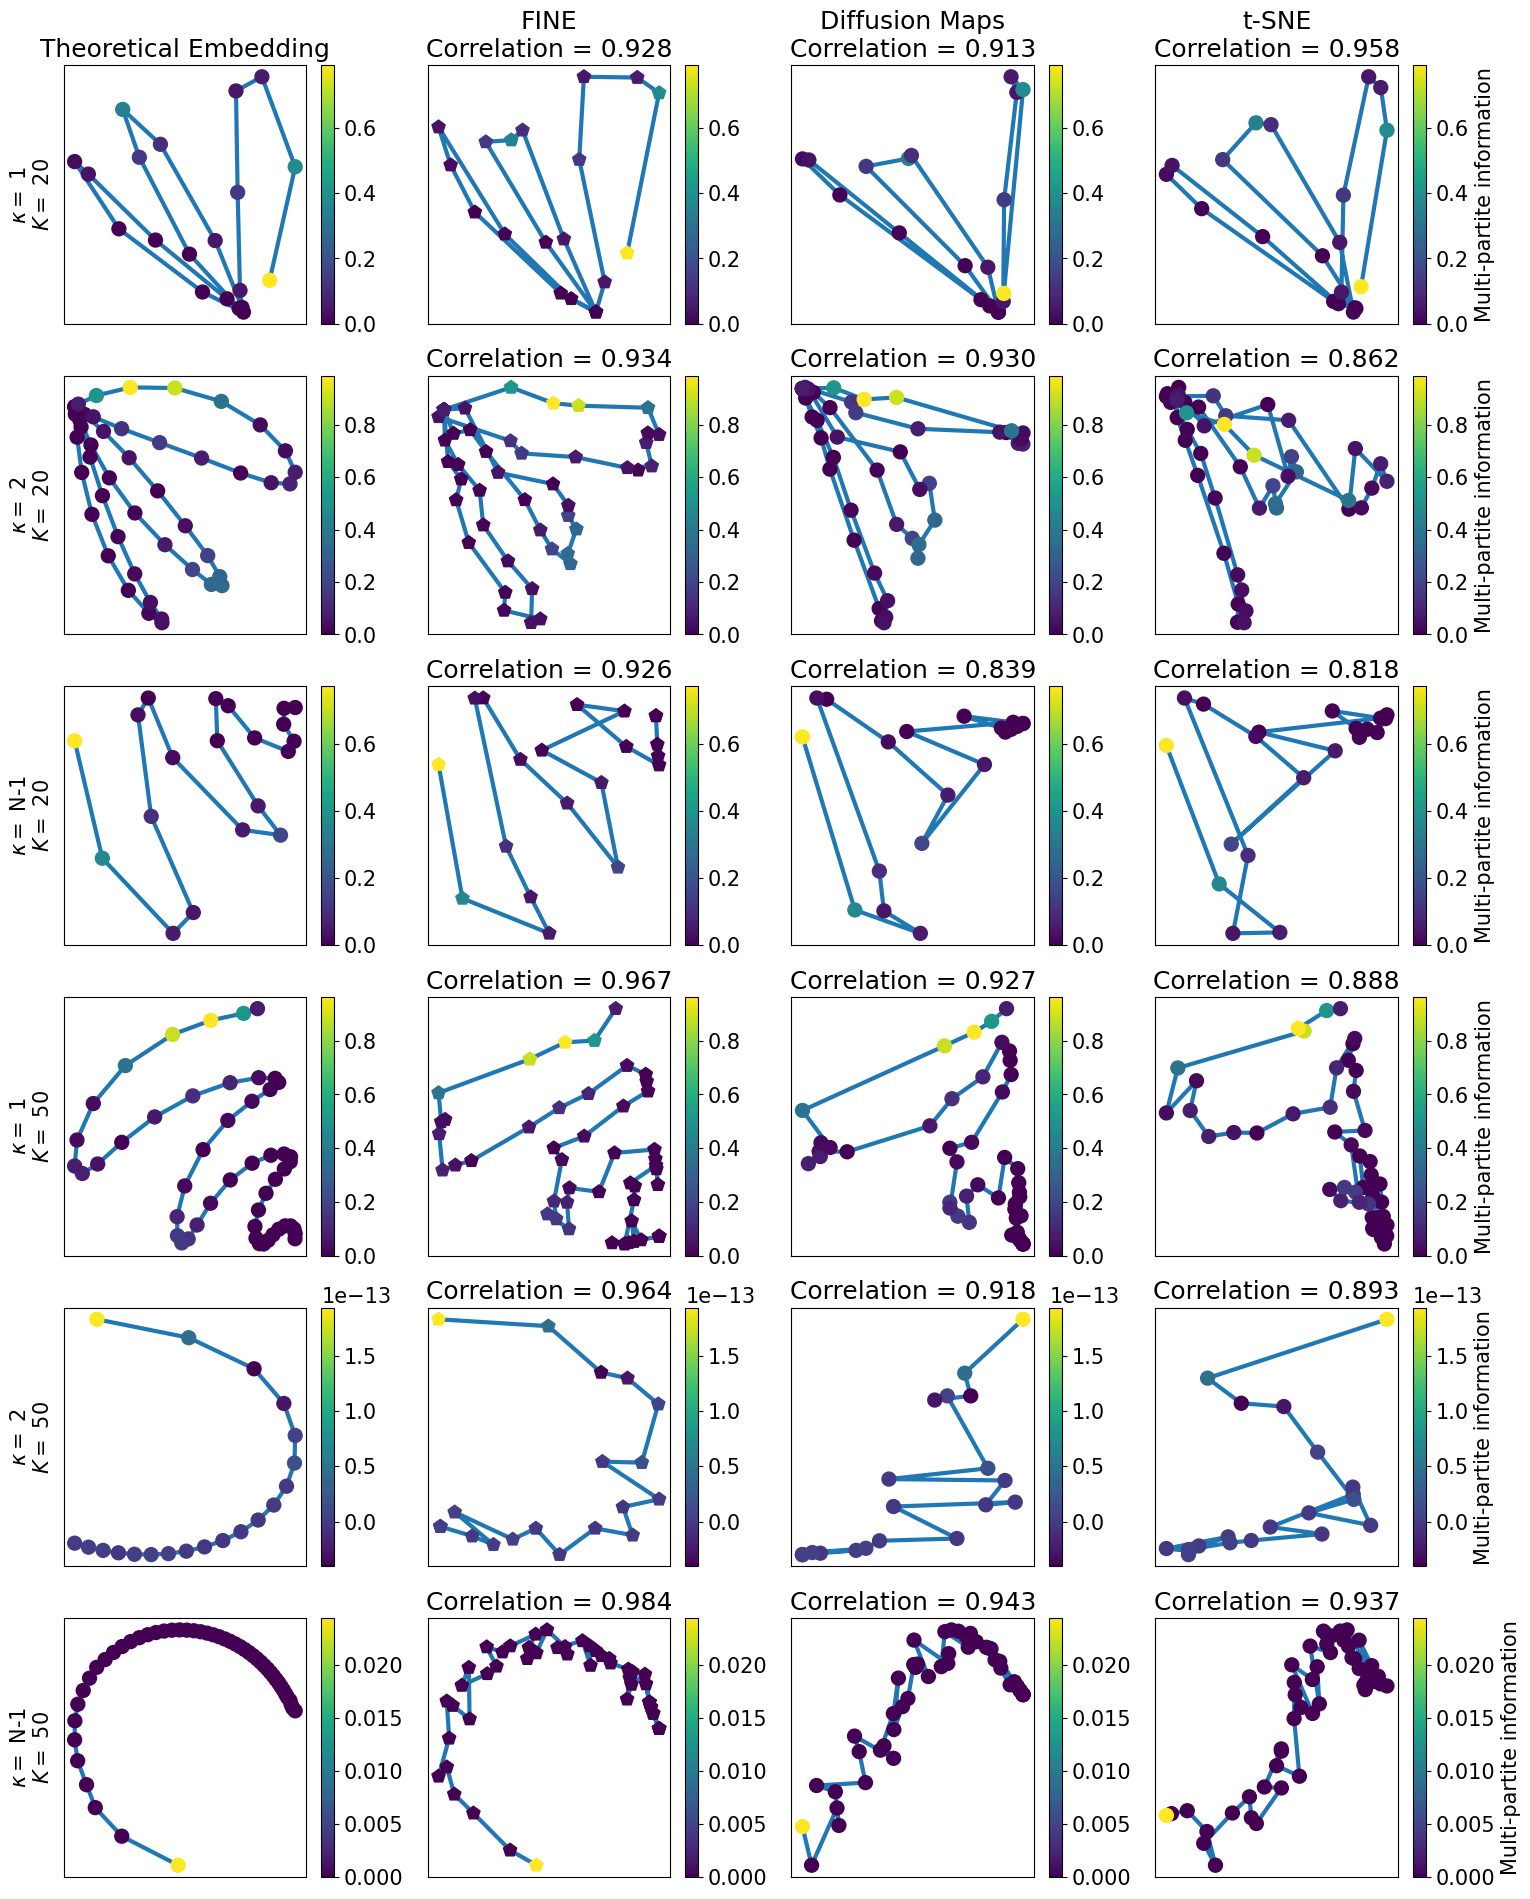

In [273]:
plt.figure(figsize=(18,24))

df_idx = 0

for i, key in enumerate(RESULTS["tsne"]):

    KLs = MI_data[key]
    
    # theoretical embedding
    true_mds = data[key]["theoretical_embedding"]
    plt.subplot(6, 4, 4*i+1)
    plt.scatter(true_mds[:,0], true_mds[:,1], marker='o', label="True FI", c=KLs, s=100, zorder=3)
    plt.plot(true_mds[:,0], true_mds[:,1], label="True FI", lw=3, zorder=2)
    if i == 0:
        plt.title("Theoretical Embedding")
    plt.xticks([])
    plt.yticks([])
    if i in [0, 3]:
        kappa = "1"
    elif i in [1, 4]:
        kappa = "2"
    else:
        kappa = "N-1"
    if i < 3:
        K = "20"
    else:
        K = "50"
    plt.ylabel(r"$\kappa = $ " + kappa + "\n" + r"$K = $ " + K)
    cb = plt.colorbar()
    cb.ax.yaxis.set_offset_position('left')
    cb.update_ticks()
    
    
    # Fisher information
    mds_joint = RESULTS["fine"][key][df_idx]["none"]["coords"]
    fi_corr = RESULTS["fine"][key][df_idx]["none"]["corr"]
    plt.subplot(6, 4, 4*i+2)
    plt.scatter(mds_joint[:,0], mds_joint[:,1], marker='p', label="FI Joint", c=KLs, s=100, zorder=3)
    plt.plot(mds_joint[:,0], mds_joint[:,1],  label="FI Joint", lw=3, zorder=2)
    if i == 0:
        plt.title("FINE\nCorrelation = %.3f" % fi_corr)
    else:
         plt.title("\nCorrelation = %.3f" % fi_corr)
    plt.xticks([])
    plt.yticks([])
    cb = plt.colorbar()
    cb.ax.yaxis.set_offset_position('left')
    cb.update_ticks()
    
    
    # Diffusion maps
    dm = RESULTS["dm"][key][df_idx][best_params[key]["dm"]]["coords"]
    dm_corr = RESULTS["dm"][key][df_idx][best_params[key]["dm"]]["corr"]
    
    plt.subplot(6, 4, 4*i+3)
    plt.scatter(dm[:,0], dm[:,1], label="Diffusion Maps", c=KLs, s=100, zorder=3)
    plt.plot(dm[:,0], dm[:,1], lw=3, zorder=2)
    if i == 0:
        plt.title("Diffusion Maps\nCorrelation = %.3f" % dm_corr)
    else:
        plt.title("\nCorrelation = %.3f" % dm_corr)
    plt.xticks([])
    plt.yticks([])
    cb = plt.colorbar()
    cb.ax.yaxis.set_offset_position('left')
    cb.update_ticks()
    

    # T-SNE
    plt.subplot(6, 4, 4*i+4)
    tsne = RESULTS["tsne"][key][df_idx][best_params[key]["tsne"]]["coords"]
    tsne_corr = RESULTS["tsne"][key][df_idx][best_params[key]["tsne"]]["corr"]
    
    plt.scatter(tsne[:,0], tsne[:,1], label="t-SNE", c=KLs, s=100, zorder=3)
    plt.plot(tsne[:,0], tsne[:,1],  label="t-SNE", lw=3, zorder=2)
    if i == 0:
        plt.title("t-SNE\nCorrelation = %.3f" % tsne_corr)
    else:
        plt.title("Correlation = %.3f" % tsne_corr)
    plt.xticks([])
    plt.yticks([])
    cb = plt.colorbar(label="Multi-partite information")
    cb.ax.yaxis.set_offset_position('left')
    cb.update_ticks()


plt.savefig("embedding_comparison.pdf")
plt.show()